In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

## Load the model

In [2]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

## Load Dataset

In [3]:
def rotate_point(angle: float, cx: float, cy: float, x: float, y: float):
    s = np.sin(angle)
    c = np.cos(angle)
    x -= cx
    y -= cy
    
    x_new = x * c - y * s
    y_new = x * s + y * c
    
    x = x_new + cx
    y = y_new + cy
    return x, y

In [4]:
# Load the test data
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
data_params = {'batch_size': 32, 'shuffle': False, 'num_workers': 4}
test_loader = data.DataLoader(test_set, **data_params)

In [5]:
test_iter = iter(test_loader)

In [6]:
example_samples = [
    next(test_iter) for _ in range(10)
]

example_images = [x[0] for x in example_samples]
example_ground_truth = [x[1] for x in example_samples]

## Inference and visualization

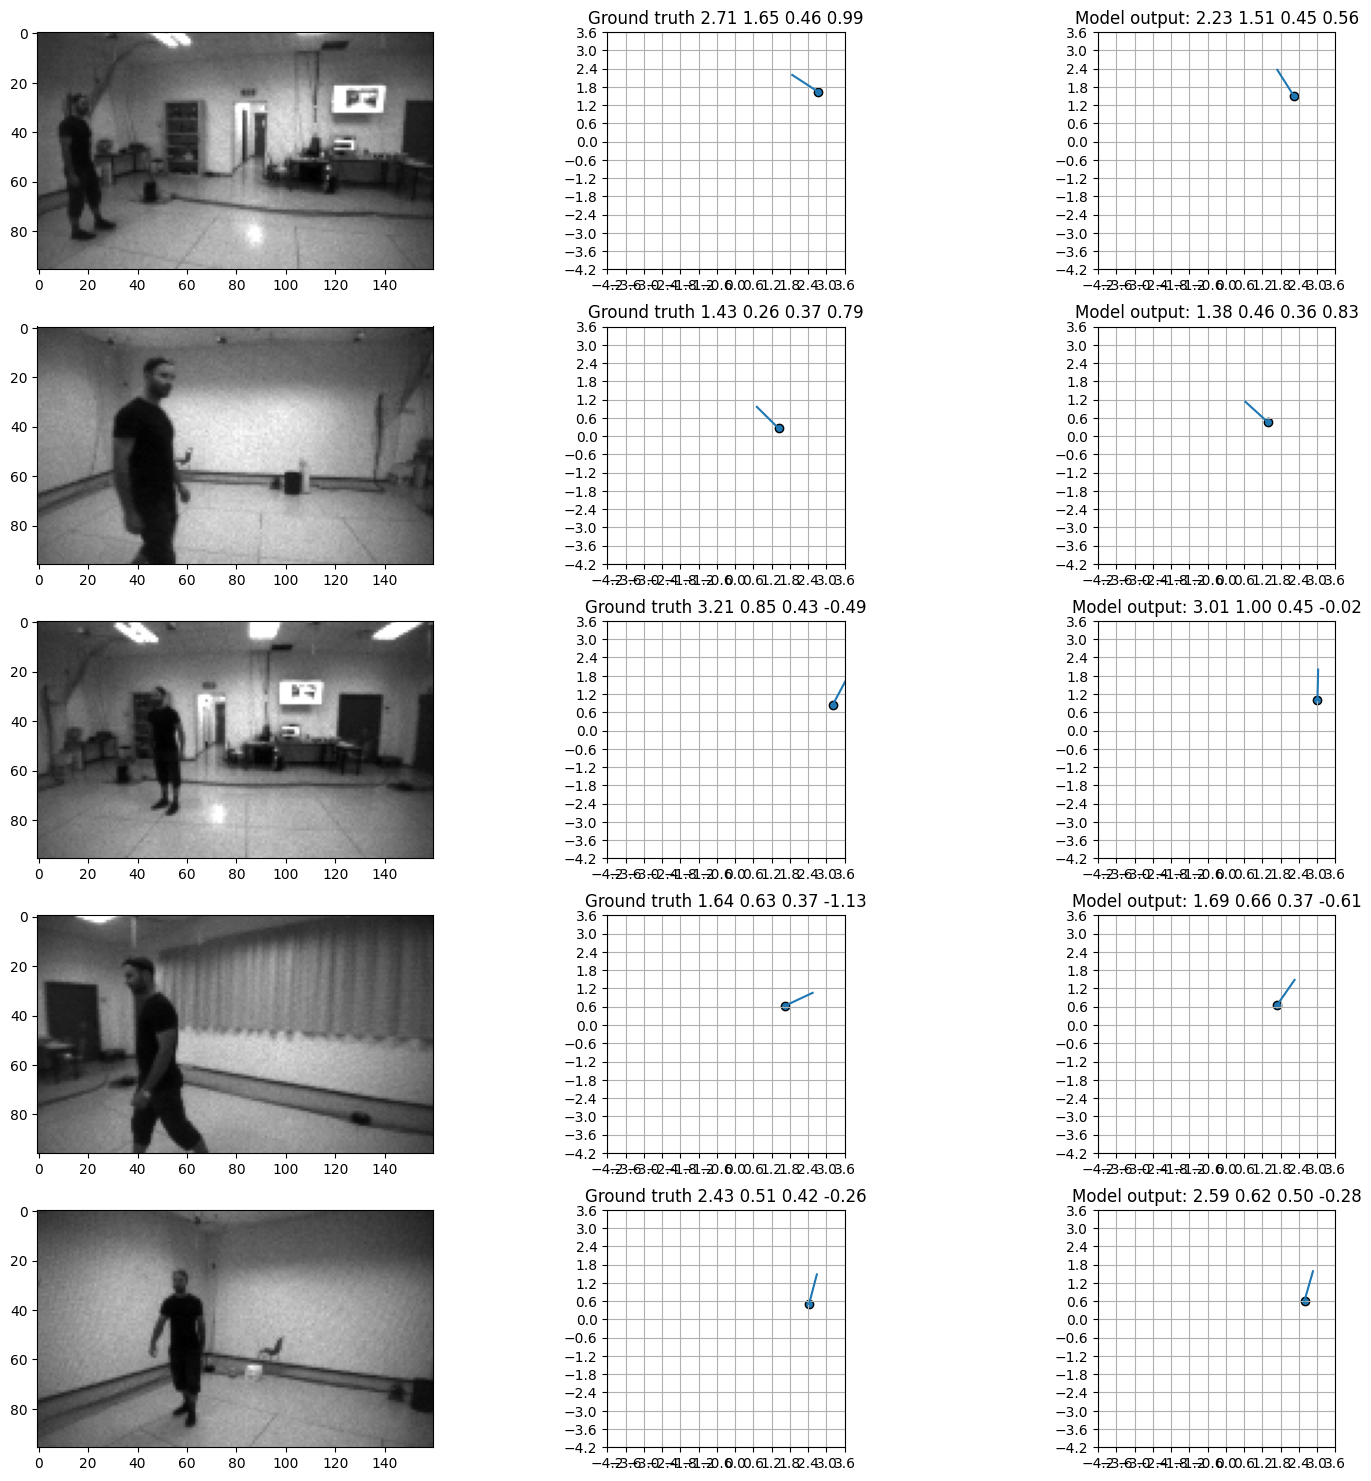

In [7]:
nrows = 5
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
fig.tight_layout(pad=2)

for i in range(nrows):
    axes[i][0].imshow(
        example_images[i].numpy()[0][0],
        cmap='gray'
    )
     
    for j in range(1, 3):
        min_range, max_range = -4.2, 3.6
        axes[i][j].set_xlim(min_range, max_range)
        axes[i][j].set_ylim(min_range, max_range)
        axes[i][j].set_xticks(np.arange(min_range, max_range, 0.6))
        axes[i][j].set_yticks(np.arange(min_range, max_range, 0.6))
        axes[i][j].set_aspect('equal')
        axes[i][j].grid()
    
    x, y, z, theta = example_ground_truth[i][0].numpy()
        
    new_x, new_y = rotate_point(angle=theta, cx=x, cy=y, x=x, y=y + 1)
    axes[i][1].scatter(x, y, edgecolors="black")
    axes[i][1].plot((x, new_x), (y, new_y))
    axes[i][1].set_title(f"Ground truth {x:.2f} {y:.2f} {z:.2f} {theta:.2f}")
    
    model_output = [x[0].detach().numpy() for x in model(example_images[i])]
    x, y, z, theta = map(float, model_output)
    new_x, new_y = rotate_point(angle=theta, cx=x, cy=y, x=x, y=y + 1)
    axes[i][2].scatter(x, y, edgecolors="black")
    axes[i][2].plot((x, new_x), (y, new_y))
    axes[i][2].set_title(f"Model output: {x:.2f} {y:.2f} {z:.2f} {theta:.2f}")

## Train a patch

In [8]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
train_model = FrontnetModel()
ModelManager.Read(model_path, train_model)
train_model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [63]:
# Load the train data
trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_train, x_validation, y_train, y_validation] = DataProcessor.ProcessTrainData(trainset_path)

# Create the PyTorch data loaders
data_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 1}
training_set = Dataset(x_train[0:2], y_train[0:2], train=True)
training_generator = data.DataLoader(training_set, **data_params)
validation_set = Dataset(x_validation, y_validation, train=False)
validation_generator = data.DataLoader(validation_set, **data_params)
trainer = ModelTrainer(train_model)

In [69]:
n_epochs = 5
patch_height = 96
patch_width = 160
epsilon = 0.1
criterion = nn.MSELoss()
adv_patch_cpu = torch.full((2, 1), 4)
# adv_patch_cpu.requires_grad_(True)
optimizer = optim.Adam([adv_patch_cpu], lr=0.01, amsgrad=True)

In [70]:
import cv2


def apply_path(
    img: torch.Tensor,
    x: int,
    y: int,
    size: int,
) -> torch.Tensor:
    cv2.circle(img, (x, y), size, [255], -1)

In [72]:
train_model = train_model.to('cpu')
for epoch in tqdm(range(n_epochs)):
    for X, Y in training_generator:
        output_base = train_model(X.to('cpu'))
        
        for x in X:
            x = x.to('cpu').numpy()[0]
            apply_path(
                img=x,
                x=int(adv_patch_cpu[0][0]),
                y=int(adv_patch_cpu[1][0]),
                size=10,
            )
        
        X = torch.clamp(X, 0, 255)
   
        output = train_model(X.to('cpu')) 
        loss = criterion(output[0], output_base[0].to('cpu'))  # x coordinate loss
     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        adv_patch_cpu.data.clamp_(0, 100)

100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


In [73]:
adv_patch_cpu

tensor([[4],
        [4]])

In [25]:
train_model = train_model.to('cpu')
for epoch in tqdm(range(n_epochs)):
    for X, Y in training_generator:
        print(adv_patch_cpu)
        print(adv_patch_cpu[0].shape)
        print(X.shape)
        print(X[0][0][0].shape)
        X[0][0][0] += epsilon * adv_patch_cpu[0][0]
        X = torch.clamp(X, 0, 255)
        print(X)

        output = train_model(X.to('cpu'))
        loss = criterion(output[3], torch.zeros(output[3].shape).to('cpu'))  # angle loss
     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        adv_patch_cpu.data.clamp_(0, 255) 

  0%|          | 0/5 [00:00<?, ?it/s]

tensor([[100, 100, 100]])
torch.Size([3])
torch.Size([16, 1, 96, 160])
torch.Size([160])
tensor([[[[ 58.,  63.,  63.,  ...,  59.,  55.,  56.],
          [ 50.,  56.,  57.,  ...,  49.,  51.,  49.],
          [ 50.,  58.,  57.,  ...,  51.,  55.,  48.],
          ...,
          [ 92.,  90.,  84.,  ...,  69.,  65.,  66.],
          [ 85.,  91.,  97.,  ...,  66.,  63.,  60.],
          [ 89.,  88.,  87.,  ...,  63.,  66.,  63.]]],


        [[[ 58.,  59.,  59.,  ...,  55.,  56.,  49.],
          [ 62.,  63.,  65.,  ...,  54.,  49.,  47.],
          [ 59.,  66.,  61.,  ...,  61.,  56.,  50.],
          ...,
          [101., 102.,  94.,  ...,  80.,  73.,  72.],
          [102., 103., 102.,  ...,  80.,  73.,  73.],
          [101., 102.,  95.,  ...,  80.,  76.,  71.]]],


        [[[ 78.,  81.,  78.,  ...,  47.,  45.,  42.],
          [ 76.,  82.,  81.,  ...,  41.,  39.,  37.],
          [ 76.,  88.,  81.,  ...,  42.,  35.,  38.],
          ...,
          [114., 114., 112.,  ...,  76.,  77.,  

 20%|██        | 1/5 [00:10<00:42, 10.66s/it]

tensor([[100, 100, 100]])
torch.Size([3])
torch.Size([16, 1, 96, 160])
torch.Size([160])
tensor([[[[ 51.,  50.,  52.,  ..., 101.,  96.,  97.],
          [ 40.,  42.,  45.,  ...,  87.,  82.,  76.],
          [ 41.,  47.,  44.,  ...,  90.,  90.,  82.],
          ...,
          [ 37.,  43.,  44.,  ...,  96., 104., 105.],
          [ 55.,  60.,  64.,  ..., 106., 104.,  99.],
          [ 56.,  63.,  63.,  ...,  97., 102.,  98.]]],


        [[[ 75.,  73.,  73.,  ..., 255., 255., 251.],
          [ 68.,  76.,  79.,  ..., 197., 169., 119.],
          [ 71.,  78.,  73.,  ...,  87.,  76.,  59.],
          ...,
          [107., 107.,  97.,  ...,  86.,  83.,  81.],
          [ 99.,  97.,  97.,  ...,  80.,  86.,  75.],
          [ 92.,  99., 102.,  ...,  84.,  82.,  75.]]],


        [[[ 46.,  55.,  53.,  ..., 188., 126., 106.],
          [ 51.,  54.,  55.,  ...,  96.,  90.,  84.],
          [ 52.,  55.,  55.,  ...,  84.,  85.,  77.],
          ...,
          [ 78.,  75.,  81.,  ...,  51.,  53.,  

 20%|██        | 1/5 [00:16<01:05, 16.36s/it]


KeyboardInterrupt: 

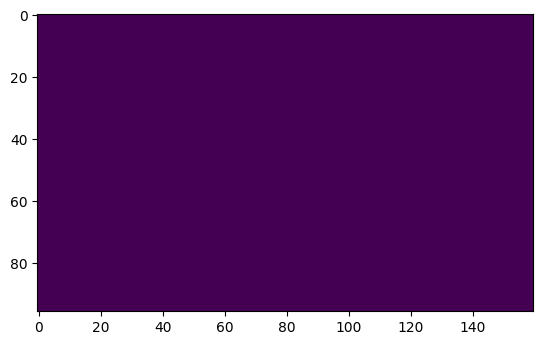

In [13]:
plt.imshow(
    adv_patch_cpu.detach().numpy()[0],
)

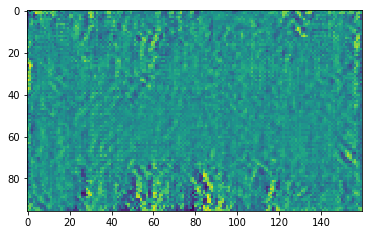

In [ ]:
plt.imshow(
    adv_patch_cpu.detach().numpy()[0],
)
plt.savefig('patch.png')

## How patch affects the image?

### Image from dataset

In [ ]:
x, y = next(iter(test_loader))

In [ ]:
[pred[0] for pred in model(x)]

[tensor([2.2261], grad_fn=<SelectBackward>),
 tensor([1.5141], grad_fn=<SelectBackward>),
 tensor([0.4459], grad_fn=<SelectBackward>),
 tensor([0.5643], grad_fn=<SelectBackward>)]

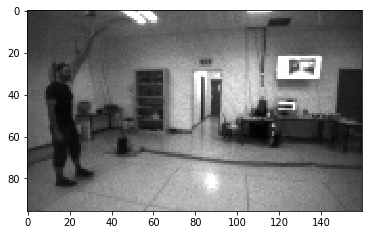

In [ ]:
plt.imshow(
    x[0].detach().numpy()[0],
    cmap='gray'
)

### Adversarial image

[2.2200968265533447, 1.50486159324646, 0.44475147128105164, 0.5530233383178711]


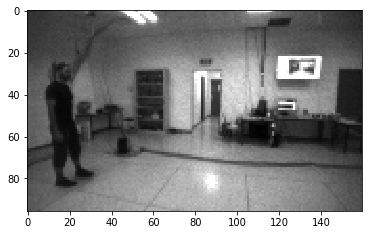

In [ ]:
epsilon = 0.01
plt.imshow(
    (x  + epsilon * adv_patch_cpu)[0].detach().numpy()[0] ,
    cmap='gray'
)
print([float(pred[0].detach().numpy()) for pred in model(x + epsilon * adv_patch_cpu)])

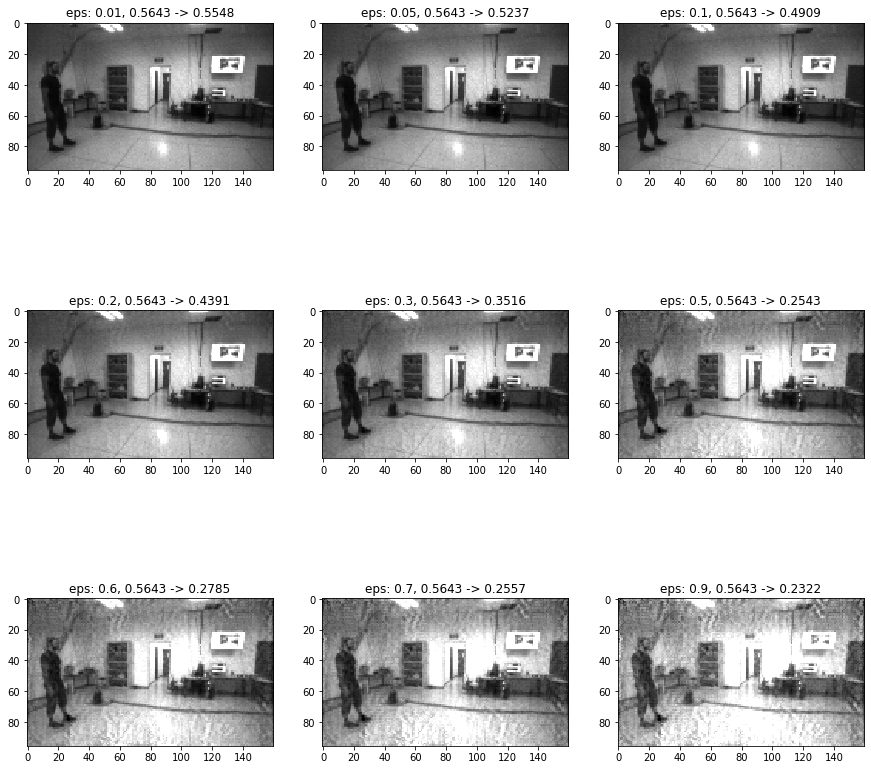

In [ ]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
# fig.tight_layout(pad=2)

epsilons = iter((0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9))
for i in range(nrows):
    for j in range(ncols):
        epsilon = next(epsilons)
        img = ((x  + epsilon * adv_patch_cpu).data.clamp_(0, 255))[0].detach().numpy()[0]
        pred = float(model((x + epsilon * adv_patch_cpu).data.clamp_(0, 255))[3][0].detach().numpy())
        axes[i][j].imshow(
            img,
            cmap='gray'
        )
        axes[i][j].set_title(f"eps: {epsilon}, 0.5643 -> {pred:.4f}")

## Use gaussian noise

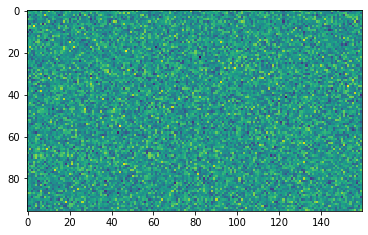

In [ ]:
noise_patch = np.random.normal(0, 50, size=(96, 160)).astype(np.float32)
plt.imshow(
    noise_patch
)

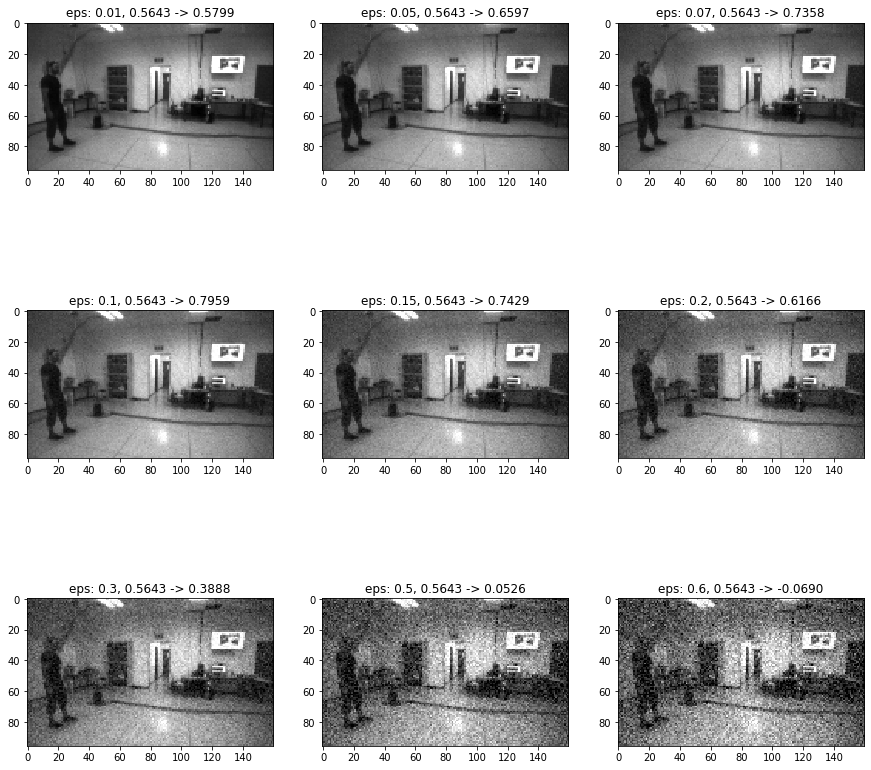

In [ ]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
# fig.tight_layout(pad=2)

epsilons = iter((0.01, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5, 0.6))
for i in range(nrows):
    for j in range(ncols):
        epsilon = next(epsilons)
        img = ((x  + epsilon * noise_patch).data.clamp_(0, 255))[0].detach().numpy()[0]
        pred = float(model((x + epsilon * noise_patch).data.clamp_(0, 255))[3][0].detach().numpy())
        axes[i][j].imshow(
            img,
            cmap='gray'
        )
        axes[i][j].set_title(f"eps: {epsilon}, 0.5643 -> {pred:.4f}")